In [44]:
import matplotlib.pyplot as plt 
import numpy as np  
import pandas as pd  
import seaborn as sns  
import gower
from scipy.cluster.hierarchy import cophenet, linkage, dendrogram  # to perform cluster analysis
from scipy.spatial.distance import pdist, squareform  # to calculate distances and convert between condensed and square forms of a distance matrix
from sklearn.preprocessing import MinMaxScaler  # To standardize our data before clustering


In [ ]:
subset_df = pd.read_csv("my_dataset.tsv", sep="\t")
subset_df.head()
subset_df.info()

In [ ]:
type(subset_df.info())

In [47]:
subset_df["interview_date"] = pd.to_datetime(subset_df["interview_date"])

In [ ]:
subset_df.info()

In [49]:
categ_df = subset_df.select_dtypes(include=["object"])
categ_df.head()

,subjectkey,sex,site_id_l,mri_info_manufacturer
0,NDAR_INVPBJTJ0Z3,M,site10,GE MEDICAL SYSTEMS
1,NDAR_INVZZJ3A7BK,F,site06,SIEMENS
2,NDAR_INVM255ZJ8M,M,site05,SIEMENS
3,NDAR_INVUFVGYBER,F,site14,SIEMENS
4,NDAR_INVJ04E024W,M,site06,SIEMENS


In [50]:
categ_features = pd.get_dummies(categ_df, drop_first=True)

In [51]:
categ_features.shape

(1000, 1023)

In [52]:
num_df = subset_df.select_dtypes(include=["float64", "int64"])
num_df.head()

,interview_age,anthroheightcalc,anthroweightcalc,ehi_y_ss_scoreb,neighborhood_crime_y,ksads_ptsd_raw_763_p,ksads_8_29_t,ksads_25_33_t,ksads_13_929_t,pps_y_ss_severity_score,prosocial_q2_y,prosocial_q3_y,rsfmri_c_ngd_meanmotion,smri_vol_cdk_total,smri_vol_scs_amygdalalh
0,108,55.000,98.25,1,5.0,0.0,0,555,555,10.0,0.0,1.0,0.250463,606974.0,1373.3
1,122,59.000,137.00,1,5.0,0.0,0,555,555,6.0,2.0,2.0,0.246895,589427.0,1528.4
2,108,55.250,74.00,1,5.0,0.0,0,555,555,8.0,1.0,1.0,0.149329,706155.0,2201.5
3,122,57.625,72.50,1,5.0,0.0,0,555,555,31.0,2.0,2.0,0.088020,654832.0,1548.7
4,112,54.000,69.00,1,5.0,0.0,0,555,555,3.0,2.0,1.0,0.090849,622518.0,1669.7


In [53]:
minmax = MinMaxScaler(feature_range=(0, 1))

num_features = pd.DataFrame(
    minmax.fit_transform(num_df),
    index=num_df.index,
    columns=num_df.columns
)

In [54]:
df_scaled = pd.concat([num_features, categ_features], axis="columns")

# Confirm that all data lies between zero and one.
print(f"Data min, max: {df_scaled.min().min(), df_scaled.max().max()}")

Data min, max: (0.0, 1.0)


In [66]:
df_scaled.shape

(1000, 1038)

In [67]:
dist = gower.gower_matrix(df_scaled.T).astype(np.float64)

In [68]:
dist.shape

(1038, 1038)

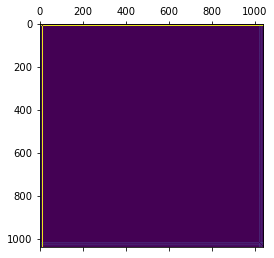

In [69]:
plt.matshow(dist)

In [59]:
dist = squareform(dist) # Upper triangular matrix

In [60]:
Z = linkage(dist, method="complete", optimal_ordering=True)
Z[:6,:]

array([[7.00000000e+00, 8.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [6.00000000e+00, 6.75000000e+02, 2.52252248e-05, 2.00000000e+00],
       [1.03800000e+03, 7.82000000e+02, 1.00000005e-03, 3.00000000e+00],
       [2.85000000e+02, 1.50000000e+01, 2.00000009e-03, 2.00000000e+00],
       [1.60000000e+01, 7.50000000e+02, 2.00000009e-03, 2.00000000e+00],
       [1.70000000e+01, 7.53000000e+02, 2.00000009e-03, 2.00000000e+00]])

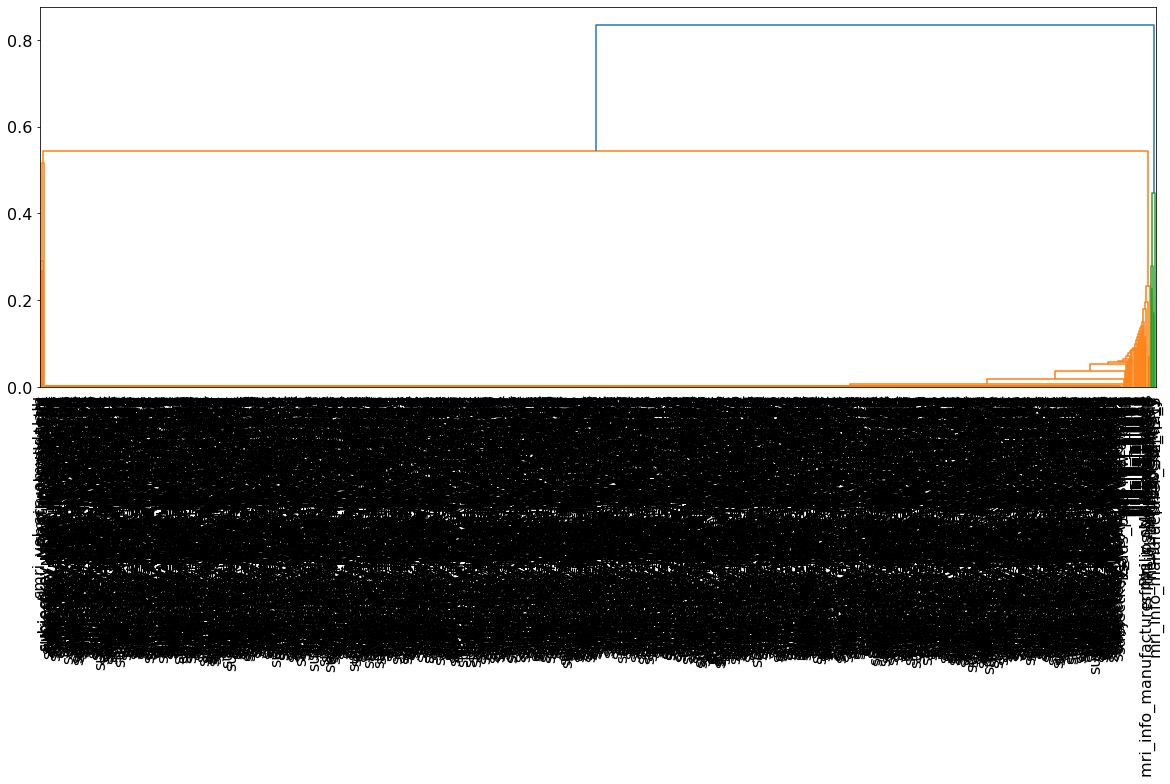

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
dn = dendrogram(
    Z,
    ax=ax,
    orientation="top",
    distance_sort='descending',
    show_leaf_counts=True,
)

# `dn["ivl"] stores a list of the feature indices in the order they appear on the x axis.
# Let's label the x-axis using the actual feature names rather than the indices
_ = ax.set_xticklabels(
    [list(df_scaled.columns)[int(i)] for i in dn["ivl"]],
    rotation=90,
    fontsize=16,
)

yticks = np.linspace(0.0, 0.8, 5)
_ = ax.set_yticks(yticks)
_ = ax.set_yticklabels([round(y, 1) for y in yticks], fontsize=16)

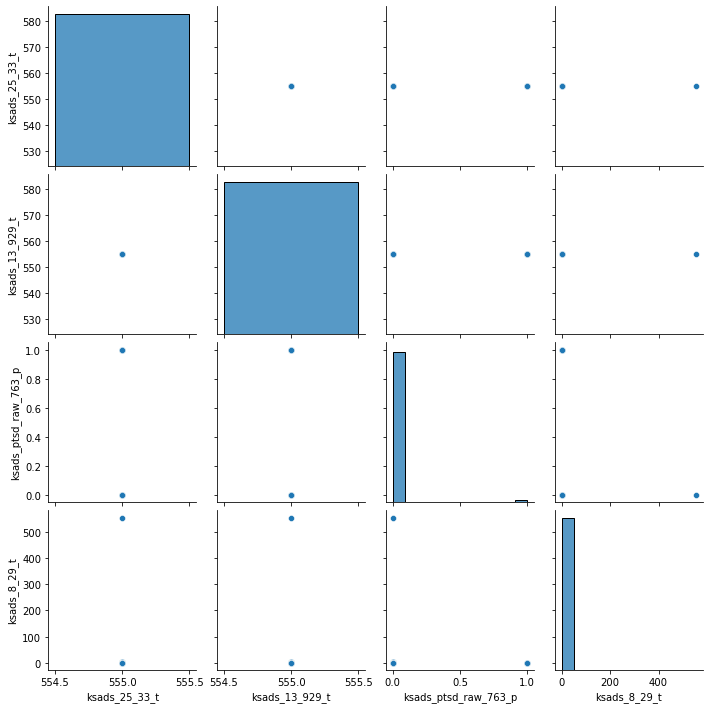

In [63]:
_ = sns.pairplot(
    subset_df,
    vars=["ksads_25_33_t", "ksads_13_929_t", "ksads_ptsd_raw_763_p", "ksads_8_29_t"]
)

In [64]:
c, coph_dists = cophenet(Z, pdist(df_scaled.T.values, "cityblock"))
print(f"Cophenetic correlation coefficient: {c}")

Cophenetic correlation coefficient: 0.9835332625649048


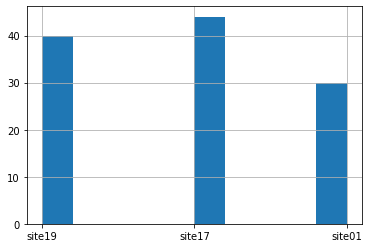

In [65]:
_ = subset_df[subset_df["mri_info_manufacturer"] == "Philips Medical Systems"]["site_id_l"].hist()